gathering from serveral resources:
1. https://bayesianbrad.github.io/posts/2019_hmc.html
2. https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/

I change it to use jax

In [1]:
from jax import grad
import jax.numpy as jnp
import numpy as np
import jax.scipy.stats as jst
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
def neg_log_prob(x, mu=0, sigma=1):
    return -jst.norm.logpdf(x, mu, sigma)

In [3]:
grad_f = grad(neg_log_prob)

In [4]:
neg_log_prob(2.5), grad_f(2.5)

(DeviceArray(4.0439386, dtype=float32, weak_type=True),
 DeviceArray(2.5, dtype=float32, weak_type=True))

From mechanic statistics, we know energy distribution $P(E) \propto e(-E/T)$, or energe proportional to i.e $E \propto -log(P(E))$. 

Our goal is to sample variable vector q, which can be viewed as a position, $\pi(q)$. Instead of sampling it directly, we introduct extra meomentum variables vector $p$ to get joint distribution  $\pi(q, p)$. If we can sample \$pi(q, p$, we then marginalize out (throwing away) $p$, we effectively sample $\pi(q)$.

All those sounds introducing complexity without any benefit. But if we define Hamiltonian $H(q, p) = -log(\pi(q, p)$ (as energy is proportional to negative log), we can following following its tradjectory, which is effectively sampling $\pi(q, p)$.

To simply our problem, we can introduce independence between $q$ and $p$ and $K(p)$ to be $\frac{p^2}{2}$, so we have:
    $$
    \begin{align}
    H(q, p) & = -log(\pi(q)) - log(\pi(p)) \\
            & = V(q) + K(p)  \\
      V(q)  & = -log(\pi(q)) \\
      K(p)  & = -log(\pi(p)) \\
            & = \frac{1}{2}p^{T}p
    \end{align}
    $$
    
Under Hamiltonian, we have:
    $$
    \begin{align}
    \frac{\partial q}{\partial t} & = \frac{\partial H}{\partial p} \\
    & = p \\
    \frac{\partial p}{\partial t} & = -\frac{\partial H}{\partial q} \\
    & = -\frac{\partial V}{\partial q}
    \end{align}
    $$

     


In [5]:
def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p

In [6]:
def hamiltonian_monte_carlo(n_samples, 
                            negative_log_prob, 
                            initial_position, 
                            path_len=1, 
                            step_size=0.5):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """    
    # autograd magic
    dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

In [7]:
mu = 0
sigma = 1
size = 1000
x0 =  np.array(0.0)

In [8]:
trial = hamiltonian_monte_carlo(size, neg_log_prob, x0, path_len=1,step_size=0.5)

In [9]:
trial[:3]

array([ 1.528898  ,  0.8276801 , -0.25906837], dtype=float32)

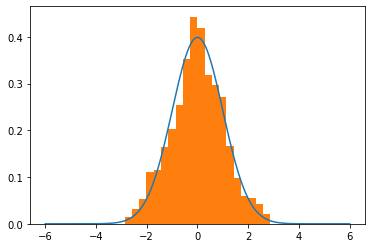

In [10]:
lines = np.linspace(-6,6,10_000)
normal_curve = [st.norm.pdf(x=l,loc=mu, scale=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=20)
plt.show()

In [31]:
def leapfrog_slow(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.
    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be
    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)
    positions, momentums = [np.copy(q)], [np.copy(p)]
    stages = [[np.copy(q), np.copy(p)]]

    velocity = dVdq(q)
    for _ in np.arange(np.round(path_len / step_size)):
        p -= step_size * velocity / 2  # half step
        stages.append([np.copy(q), np.copy(p)])
        q += step_size * p  # whole step
        stages.append([np.copy(q), np.copy(p)])
        positions.append(np.copy(q))
        velocity = dVdq(q)
        p -= step_size * velocity / 2  # half step
        stages.append([np.copy(q), np.copy(p)])
        momentums.append(np.copy(p))

    # momentum flip at end
    return q, -p, np.array(positions), np.array(momentums), np.array(stages)

In [34]:
def neg_log_mvnormal(x, mean, cov):
    return -jst.multivariate_normal.logpdf(x, mean, cov)
    
from functools import partial
neg_log_p = partial(neg_log_mvnormal, mean=np.zeros(2), cov=np.eye(2))
dVdq = grad(neg_log_p)


np.random.seed(1)
positions, momentums = [], []
for _ in range(3):
    q, p = np.random.randn(2, 2)
    _, _, q, p, _ = leapfrog_slow(q, p, dVdq, 2 * np.pi, 0.01)
    positions.append(q)
    momentums.append(p)

In [40]:
positions[:2], momentums[:2]

([array([[ 1.62434536, -0.61175641],
         [ 1.61898243, -0.62245548],
         [ 1.61345756, -0.63309234],
         ...,
         [ 1.63614166, -0.58674538],
         [ 1.63115573, -0.59758449],
         [ 1.6260066 , -0.60836387]]),
  array([[ 0.86540763, -2.3015387 ],
         [ 0.8828125 , -2.30903578],
         [ 0.90012908, -2.31630182],
         ...,
         [ 0.82476783, -2.28329468],
         [ 0.84237045, -2.29132342],
         [ 0.85988879, -2.29912305]])],
 [array([[-0.52817175, -1.07296862],
         [-0.54438841, -1.06679749],
         [-0.56055063, -1.0605197 ],
         ...,
         [-0.49041495, -1.08684695],
         [-0.50675142, -1.08092523],
         [-0.5230372 , -1.07489538]]),
  array([[ 1.74481176, -0.7612069 ],
         [ 1.73607063, -0.73815405],
         [ 1.72715592, -0.71502739],
         ...,
         [ 1.76438367, -0.81429797],
         [ 1.75604796, -0.79142487],
         [ 1.74753666, -0.76847267]])])

In [37]:
def neg_log_p_to_img(neg_log_p, extent=None, num=100):
    if extent is None:
        extent = (-3, 3, -3, 3)
    X, Y = np.meshgrid(np.linspace(*extent[:2], num), np.linspace(*extent[2:], num))
    Z = np.array([np.exp(-neg_log_p(j)) for j in np.array((X.ravel(), Y.ravel())).T]).reshape(X.shape)
    return Z, extent

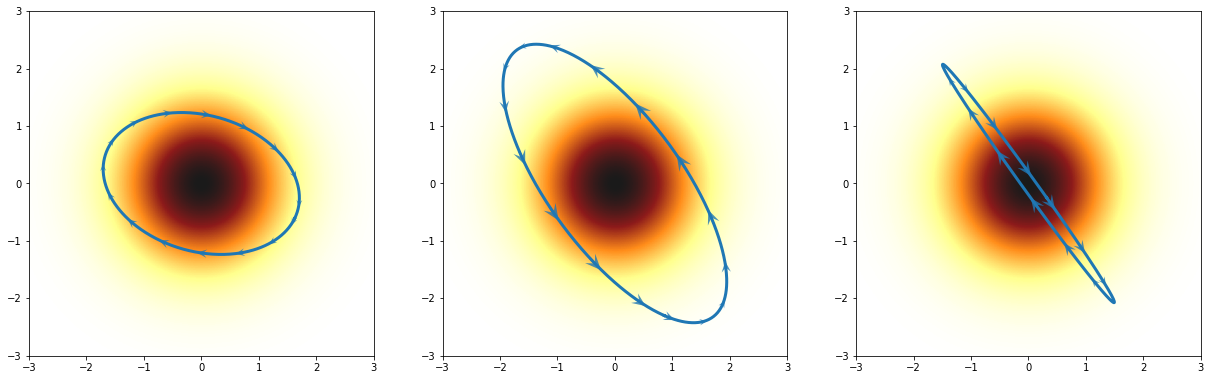

In [39]:
fig, axes = plt.subplots(ncols=len(positions), figsize=(7 * len(positions), 7))


steps = slice(None, None, 40)

Z, extent = neg_log_p_to_img(neg_log_p, (-3, 3, -3, 3), num=200)

for idx, (ax, q, p) in enumerate(zip(axes.ravel(), positions, momentums)):
    ax.imshow(Z, alpha=0.9, extent=extent, cmap='afmhot_r', origin='upper')

    ax.quiver(q[steps, 0], q[steps, 1], p[steps, 0], p[steps, 1], 
              headwidth=6, scale=60, headlength=7, alpha=0.8, color='C0')
    ax.plot(q[:, 0], q[:, 1], '-', lw=3, color='C0')
plt.savefig('normal_leapfrog.png')